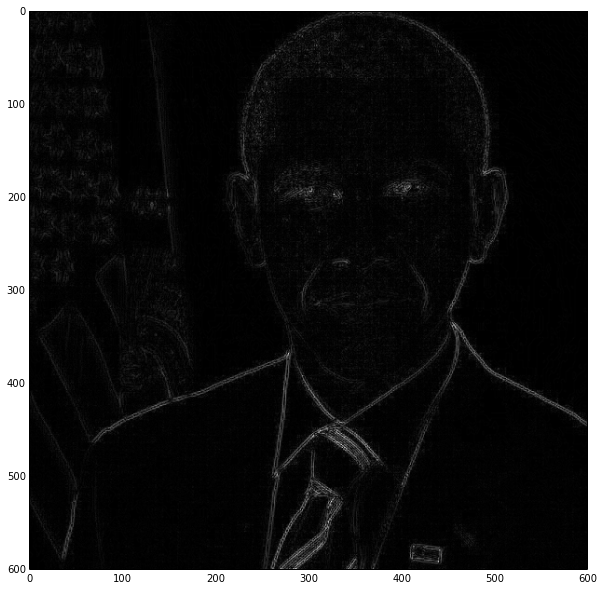

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math




img = cv2.imread('obama.jpg', 1)
fig, ax = plt.subplots(figsize=(10, 10))
laplacian = np.abs(cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),  cv2.CV_64F))

ax.imshow(laplacian, cmap='gray')


In [7]:
np.min(laplacian)

0.0

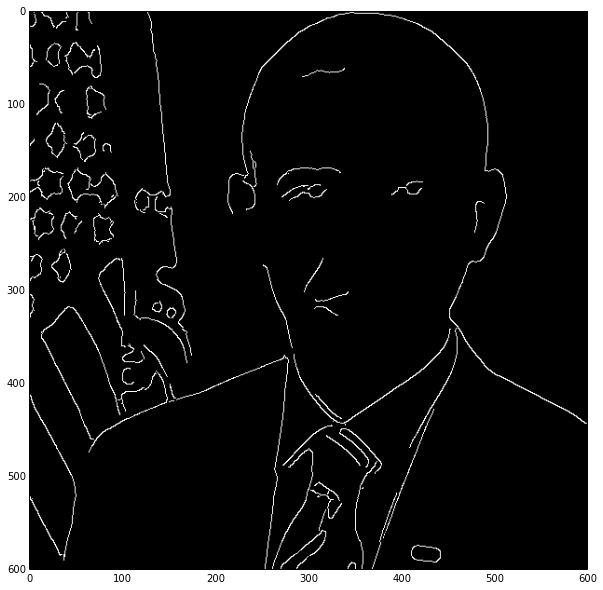

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray, 9)
v = np.median(blurred)
sigma = 0.6
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(blurred, 100, 200)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(edges, cmap='gray')  

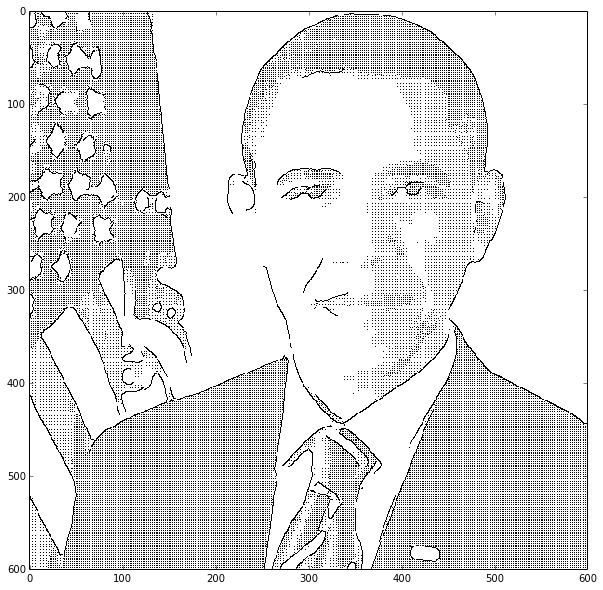

time: 321 ms


In [21]:
def line_img(shape, density):
    line_img = np.ones(shape, dtype='uint8') * 255
    dy = 1 / density
    for i in range(int(shape[0]*density + 0.5)):
        y = int(dy*i + 0.5)
        line_img[y,:] = 0
    return line_img

def dots(shape, space):
    dots_img = np.ones(shape, dtype='uint8') * 255
    dots_img[::space, ::space] = 0
    return dots_img

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 3).astype(float)


line1 = line_img(gray.shape, 0.1)
line2 = line_img(gray.shape, 1./50)
line3 = line_img(gray.shape, 1./8)
line4 = line_img(gray.shape, 1./4)
line5 = line_img(gray.shape, 1./2)

gray -= np.min(gray)
gray /= np.max(gray)


fill = np.ones_like(gray) * 255
mask = gray <= 0.2;fill[mask] = dots(gray.shape, 2)[mask]
mask = (0.2 < gray) & (gray <= 0.4); fill[mask] = dots(gray.shape, 3)[mask]
# mask = (0.4 < gray) & (gray <= 0.6); result[mask] = dots(gray.shape, 4)[mask]
# mask = (0.6 < gray) & (gray <= 0.8); result[mask] = 255#line2[mask]
# mask = (0.8 < gray) & (gray <= 1); result[mask] = 255
# result[:,:] = 255
# result[::2,::2] = 0
fill[edges == 255] = 0
cv2.imwrite('results/result.jpg', result)
height, width = gray.shape
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(fill, cmap='gray', interpolation='none')


In [10]:
import sys
sys.setrecursionlimit(64913)
def adjacent(colors, node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return 0 < (x1 - x2)**2 + (y1 - y2)**2 <= 2

def findpath(colors, nodes, path, used = set(), depth=0):
    if len(path) == len(nodes):
        return True
#     print path
    for node in nodes:
        (x, y) = node
        if (x, y) not in used and adjacent(colors, path[-1], node):
            path.append((x, y))
            used.add((x, y))
            result = findpath(colors, nodes, path, used, depth+1)
            if result: return True
            path.pop()
            used.remove((x, y))
    return False


nodes = np.argwhere(result[255:280,255:282] == 0)
(x, y) = nodes[0]
used = set([(x, y)])
path = [(x, y)]

findpath(None, nodes, path, used)


True

In [11]:
len(path)

4

In [12]:
# def dirs(i, j, costimg):
#     possible = [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)
#     valid = [(k, l) for (k, l) in p
#                 if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]]
                
#     valid = np.array(valid[0,:], valid[])
        
    

def solve_aux(costimg, maxcost, solution, used, cost):
#     print '\r%s, %s\r' % (len(solution), cost),
    arr = np.array(solution)
    x = np.sum(costimg[arr[:,0],arr[:,1]] == 0) / float(np.sum(costimg == 0))
    if np.sum(costimg[arr[:,0],arr[:,1]] == 0) == np.sum(costimg == 0):
        return True
    
#     print solution
    
    (i, j) = solution[-1]
    for (k, l) in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
        if (k, l) not in used and 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]:
            newcost = cost + costimg[k, l]
            if newcost > maxcost: continue
            solution.append((k, l))
            used.add((k, l))
            success = solve_aux(costimg, maxcost, solution, used, newcost)
            if success: return True
#             if costimg[k,l] == 0: return False
            solution.pop()
            used.remove((k, l))
    return False
            

def solve(start, costimg, maxcost):
    solution = [start]
    used = set([start])
    cost = costimg[start]
    if solve_aux(costimg, maxcost, solution, used, cost):
        return solution
    else:
        return None
    

def traceimg(start, costimg):
    solution_len = np.sum(costimg == 0)
    maxcost = 0
    solution = None
    while not solution:
        print '\r%s\r' % maxcost,
        solution = solve(start, costimg, maxcost)
        maxcost += 0.1
    return solution

def pt2ind(shape, i, j):
    return shape[1]*i + j

def ind2pt(shape, k):
    i = int(k/shape[1])
    return i, k-i
    
costimg = 1/(laplacian + 1)
costimg[edges == 255] = 0

n = costimg.size
dists = np.zeros((2, 2)) + float()
for i in xrange(n):
    dists[i, i] = 0

# for i in xrange(costimg.shape[0]):
#     for j in xrange(costimg.shape[1]):
#         for (k, l) in [(i+1, j), (i+1, j+1), (i, j+1)]:
#             if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]:
                
#                 dists[pt2ind()] = max(costimg[k, l], cost[i, j])
                

# i, j = np.argwhere(costimg==0)[0]
# solution = traceimg((i, j), costimg)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [13]:
import heapq
def dist((i,j), (k, l)):
    return (i-k)**2 + (j-l)**2

def cost(start, end, costimg):
    queue = [(0, start)]
    gscore = np.zeros_like(costimg) + float('inf')
    gscore[start] = 0
    node = None
    while node != end:
        cost, node = heapq.heappop(queue)
        (i, j) = node
        for (k, l) in [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)]:
            if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]:
                new_g = cost + costimg[k, l] + 1
                if new_g < gscore[k, l]:
                    gscore[k, l] = new_g
                    heapq.heappush(queue, (new_g, (k, l)))
    return gscore[end]

costimg = 1/(laplacian + 1) * 10
costimg[edges == 255] = 0
for i in range(100):
    cost((0,0), (50,50), costimg)



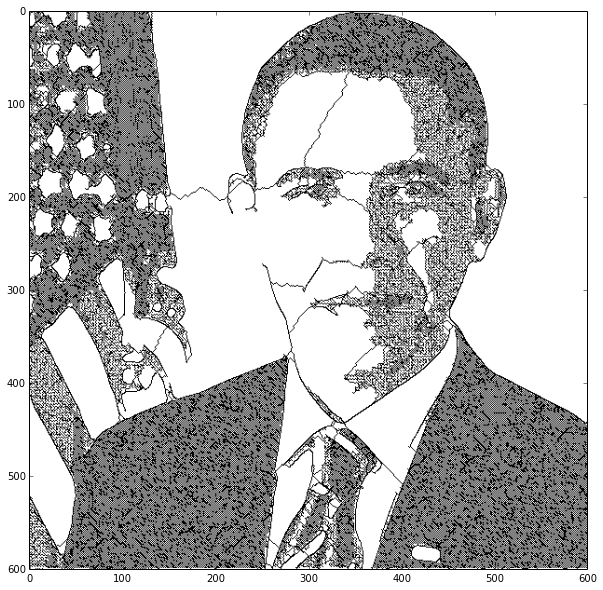

time: 2min 7s


In [22]:
def reconstruct(current, came_from):
    path = [current]
    while current in came_from.keys():
        current = came_from[current]
        path.insert(0, current)
    return path
        

def nearest(start, used, edges, costimg):
    queue = [(0, start)]
    gscore = np.zeros_like(costimg) + float('inf')
    gscore[start] = 0
    node = None
    came_from = {}
    while True:
        if len(queue) == 0:
            return False
        cost, node = heapq.heappop(queue)
        if node not in used and edges[node] == 0:
            break
        (i, j) = node
        for (k, l) in [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)]:
            if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]:
                new_g = cost + costimg[k, l] + 1
                if new_g < gscore[k, l]:
                    gscore[k, l] = new_g
                    heapq.heappush(queue, (new_g, (k, l)))
                    came_from[(k, l)] = (i, j)
    return reconstruct(node, came_from)

def nn_ts(start, edges, costimg):
    path = [start]
    used = set([start])
    city_count = 1 if edges[start] == 0 else 0
    city_n = np.sum(edges == 0)
    while city_count < city_n*2:
        i, j = path[-1]
        found = False
        for (k, l) in [(i+1, j), (i-1, j), (i, j+1), (i, j-1), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1)]:
            if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1] and (k, l) not in used and edges[k, l] == 0:
                path.append((k, l))
                used.add((k, l))
                found = True
                city_count += 1
                break
        if not found:
            sub_path = nearest((k, l), used, edges, costimg)
            if not sub_path:
                return path
            path.extend(sub_path)
            used.add(path[-1])
            city_count += 1
    return path

costimg = 1/(laplacian + 1) * 10
costimg[edges == 255] = 0
path = nn_ts((0, 0), fill, costimg)

# path = nearest((500, 50), set(), edges, costimg)
path = np.array(path)
result = np.ones_like(edges) * 255
result[path[:, 0], path[:, 1]] = 0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(result, cmap='gray')  

In [24]:
path.shape

(145649, 2)

time: 2.16 ms


In [16]:
np.sum(edges == 255) / float(path.shape[0])

0.58973210954406385

time: 18.5 ms


8086

time: 3.82 ms
